<a href="https://colab.research.google.com/github/Saishanmukh03/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing system modules
import os
import itertools
from PIL import Image

In [3]:
#Importing preprocessing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
#Importing Deep learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [5]:

# Load training data
train_dir = "/content/drive/MyDrive/brain_tumor_dataset/Training"
train_data = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        train_data.append({"Paths": image_path, "Labels": label})

train_df = pd.DataFrame(train_data)

In [6]:
# Load testing data
test_dir = "/content/drive/MyDrive/brain_tumor_dataset/Testing"
test_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        test_data.append({"Paths": image_path, "Labels": label})

test_df = pd.DataFrame(test_data)

In [7]:
# Split test data
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)
print(valid_df.shape)
print(test_df.shape)

(655, 2)
(656, 2)


In [8]:
# Define image data generators with augmentation
batch_size = 32
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Paths",
    y_col="Labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Paths",
    y_col="Labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [9]:
print(test_df.columns)


Index(['Paths', 'Labels'], dtype='object')


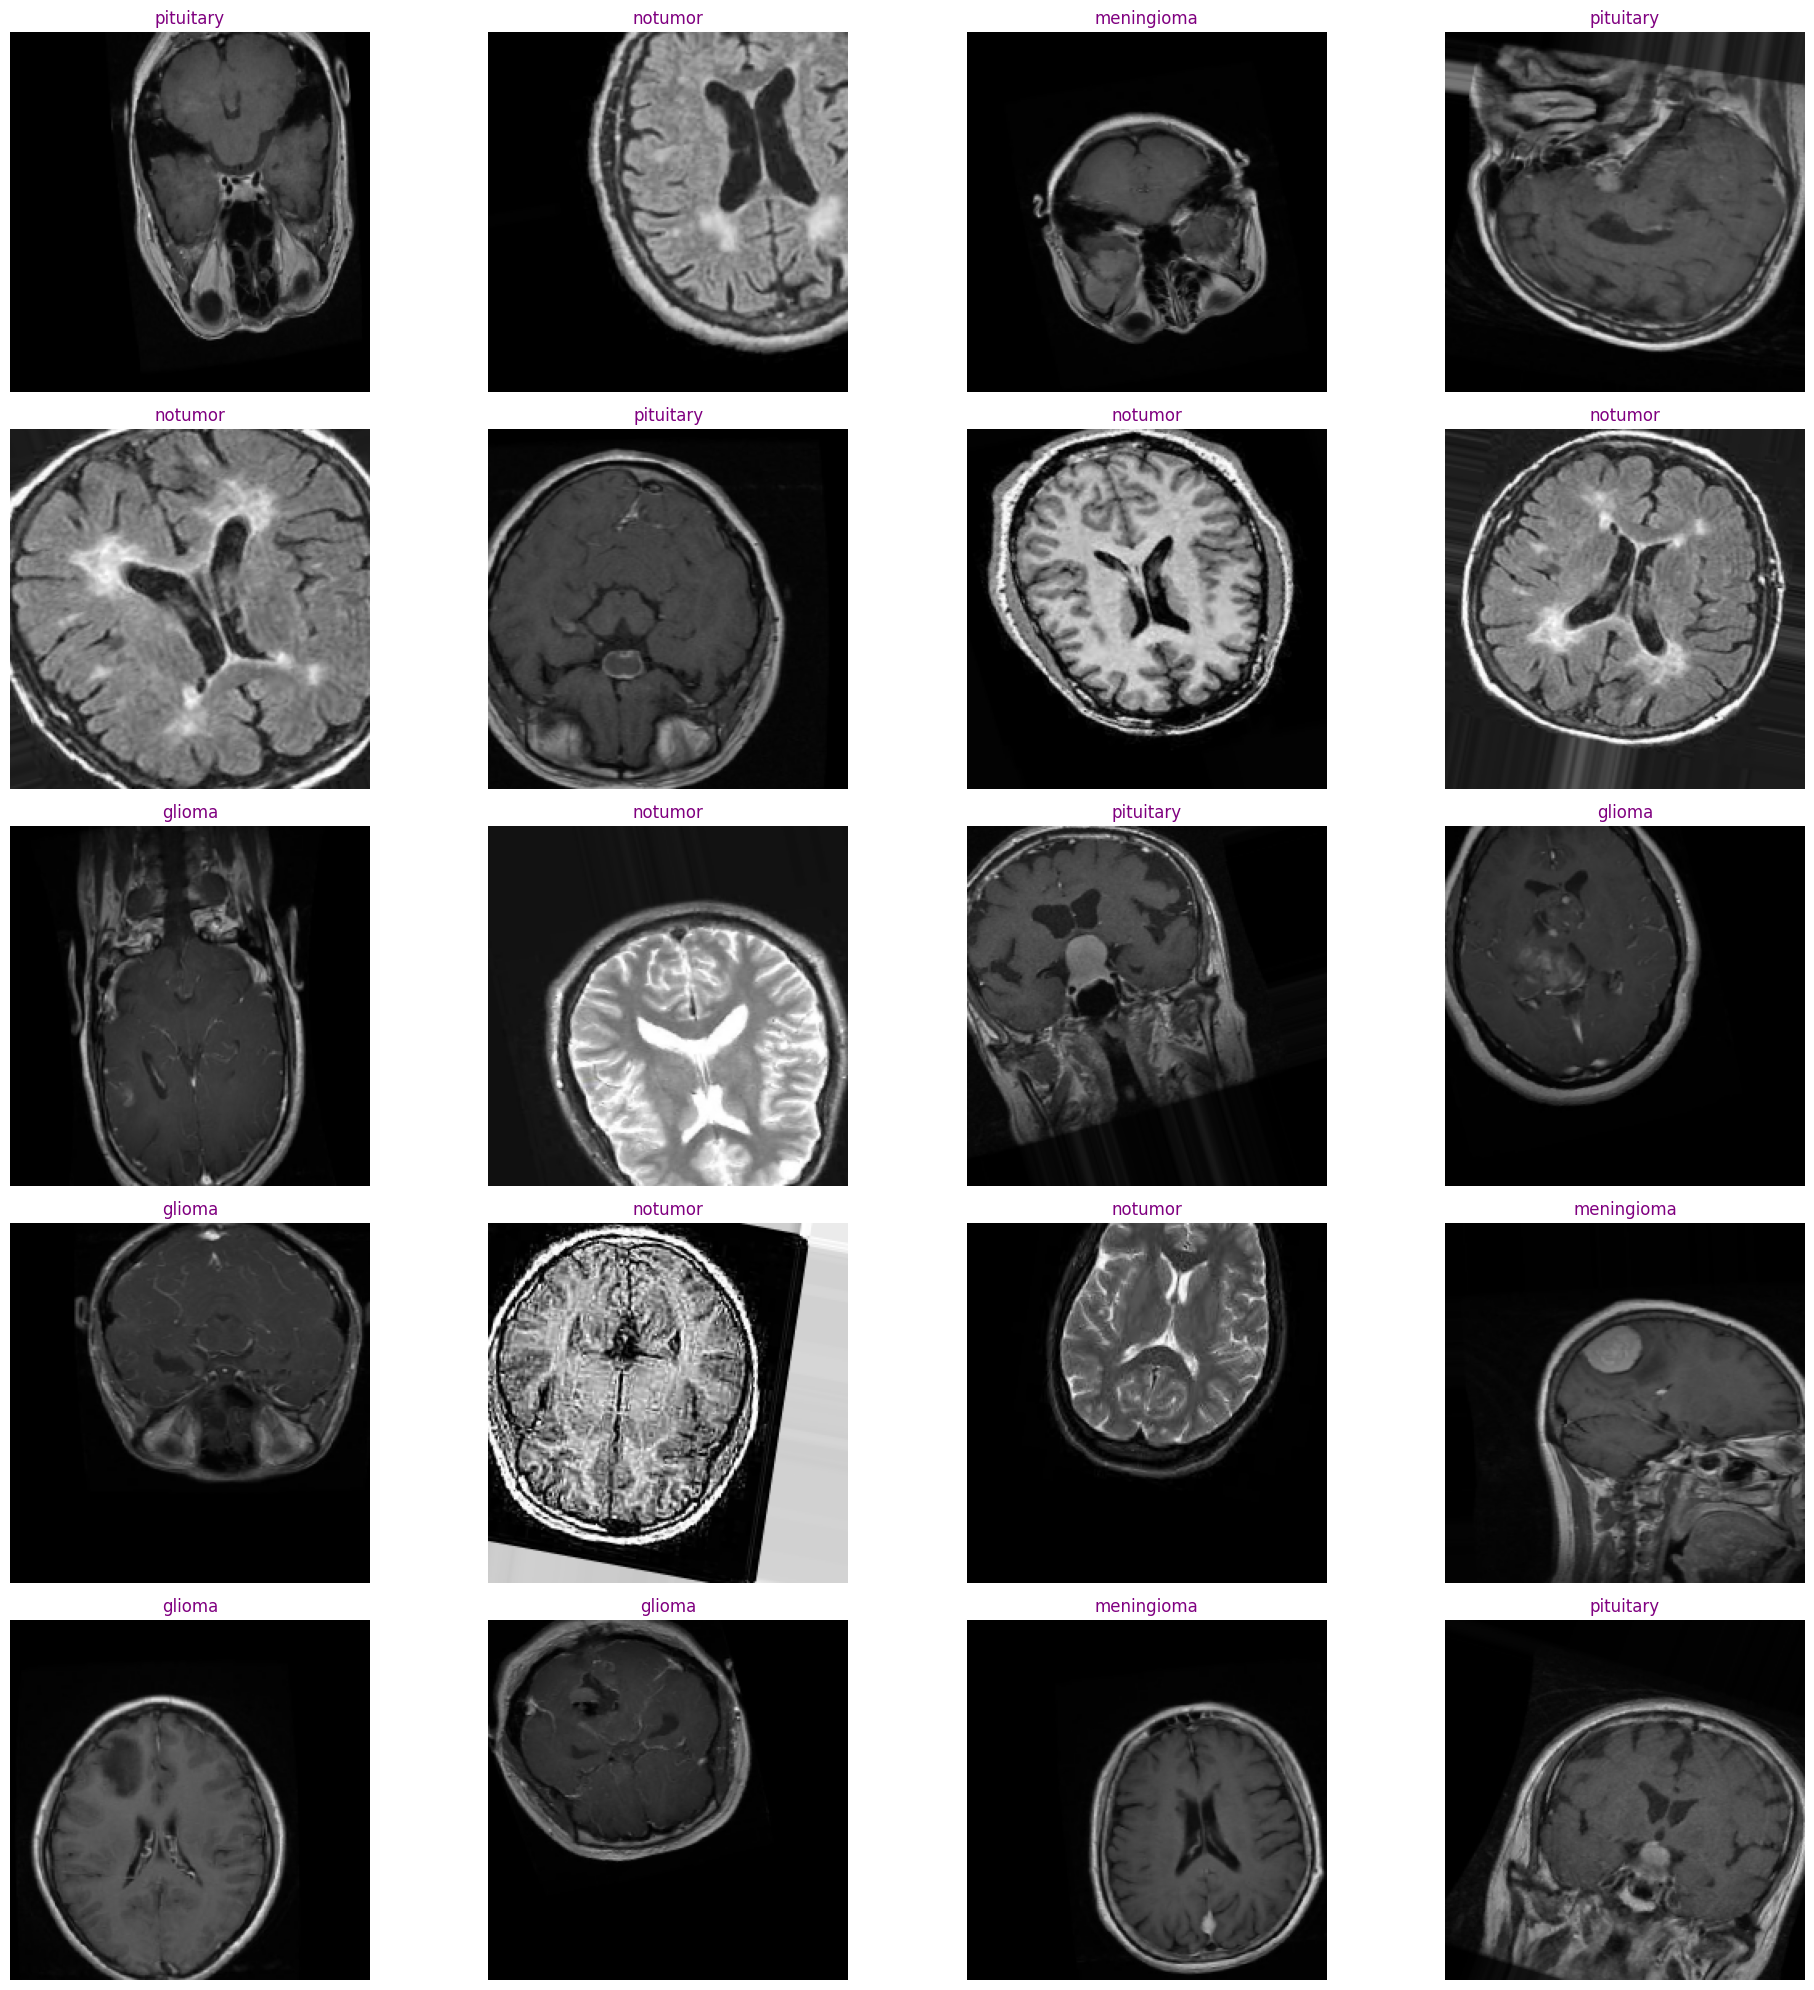

In [10]:
# Generate a batch of images for plotting
imgs, labels = next(train_generator)

# Get class indices from the generator
class_indices = train_generator.class_indices

# Get class labels
Keys = list(class_indices.keys())

# Sample plotting
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    im = imgs[i]  # Remove normalization for debugging purposes
    plt.imshow(im)

    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color="purple")
    plt.axis("off")
plt.tight_layout()
plt.show()


vgg21

In [11]:
# Define VGG21 model architecture
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
# Fine-tune the last few layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom head on top of the base model
x = base_model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)  # Additional convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # Additional max pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [13]:
# Create the modified VGG21 model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,143,108 (95.91 MB)

 Trainable params: 12,196,100 (46.52 MB)

 Non-trainable params: 12,947,008 (49.39 MB)

In [15]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True) # Changed file extension to .keras

In [17]:
# Train the model with a higher number of epochs
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3308 - loss: 2.2760
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1950s 10s/step - accuracy: 0.3311 - loss: 2.2737 - val_accuracy: 0.6250 - val_loss: 1.1053 - learning_rate: 1.0000e-05
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5176 - loss: 1.2723
Epoch 2: val_accuracy improved from 0.62500 to 0.71037, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 107s 571ms/step - accuracy: 0.5178 - loss: 1.2718 - val_accuracy: 0.7104 - val_loss: 0.7644 - learning_rate: 1.0000e-05
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.6206 - loss: 0.9363
Epoch 3: val_accuracy improved from 0.71037 to 0.76220, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 553ms/step - accuracy: 0.6208 - loss: 0.9361 - val_accuracy: 0.7622 - val_loss: 0.6793 - learning_rate: 1.0000e-05
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
# Evaluate the model
train_score = model.evaluate(train_generator, verbose=0)
test_score = model.evaluate(test_generator, verbose=0)

print('Train Accuracy:', train_score[1])
print('Test Accuracy:', test_score[1])

Train Accuracy: 0.9502801299095154
Test Accuracy: 0.9161585569381714


In [19]:
from sklearn.metrics import classification_report

# Get the true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=-1)

# Print the classification report
print(classification_report(y_true, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step
              precision    recall  f1-score   support

           0       0.19      0.17      0.18       139
           1       0.22      0.20      0.21       146
           2       0.31      0.32      0.31       222
           3       0.23      0.27      0.25       149

    accuracy                           0.25       656
   macro avg       0.24      0.24      0.24       656
weighted avg       0.25      0.25      0.25       656



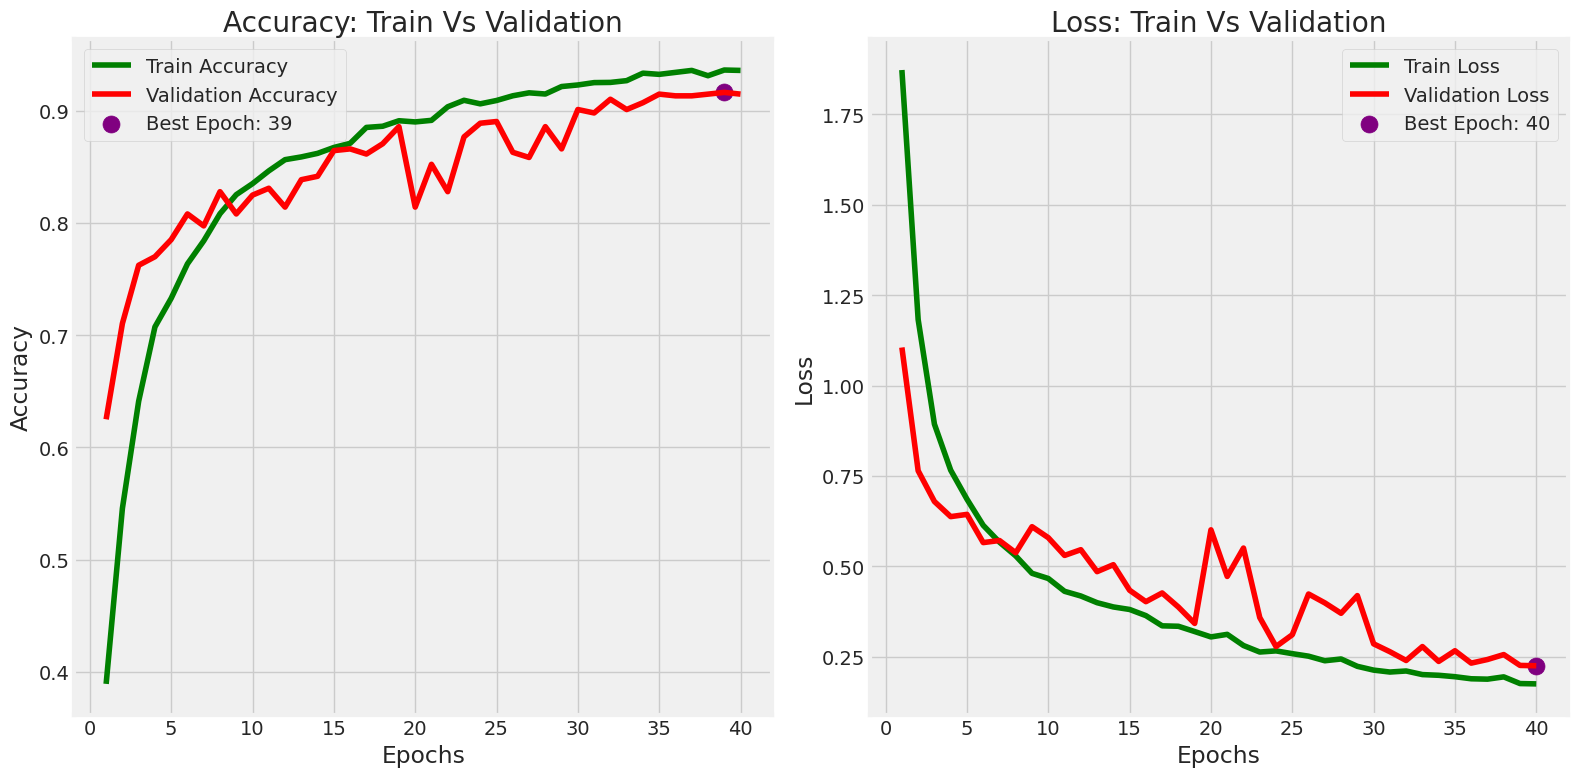

In [20]:
# Gather information from history
Epochs = range(1, len(history.history['accuracy']) + 1)
tr_acc = history.history['accuracy']
v_acc = history.history['val_accuracy']
tr_loss = history.history['loss']
v_loss = history.history['val_loss']

# Find the epoch with the highest validation accuracy and lowest validation loss
best_epoch_acc = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = history.history['val_accuracy'][best_epoch_acc - 1]

best_epoch_loss = np.argmin(history.history['val_loss']) + 1
best_val_loss = history.history['val_loss'][best_epoch_loss - 1]

# Plot visualization
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_acc, "g", label="Train Accuracy")
plt.plot(Epochs, v_acc, "r", label="Validation Accuracy")
plt.scatter(best_epoch_acc, best_val_accuracy, s=150, color='purple', label=f'Best Epoch: {best_epoch_acc}')

plt.title("Accuracy: Train Vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_loss, "g", label="Train Loss")
plt.plot(Epochs, v_loss, "r", label="Validation Loss")
plt.scatter(best_epoch_loss, best_val_loss, s=150, color='purple', label=f'Best Epoch: {best_epoch_loss}')

plt.title("Loss: Train Vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


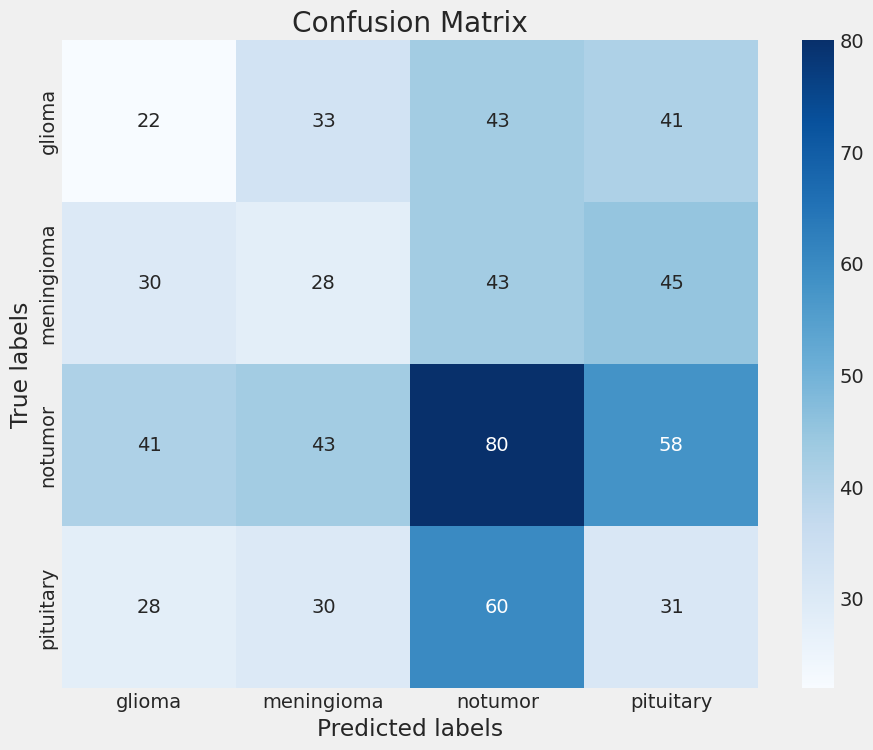

In [21]:
# Make predictions on the test data
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step


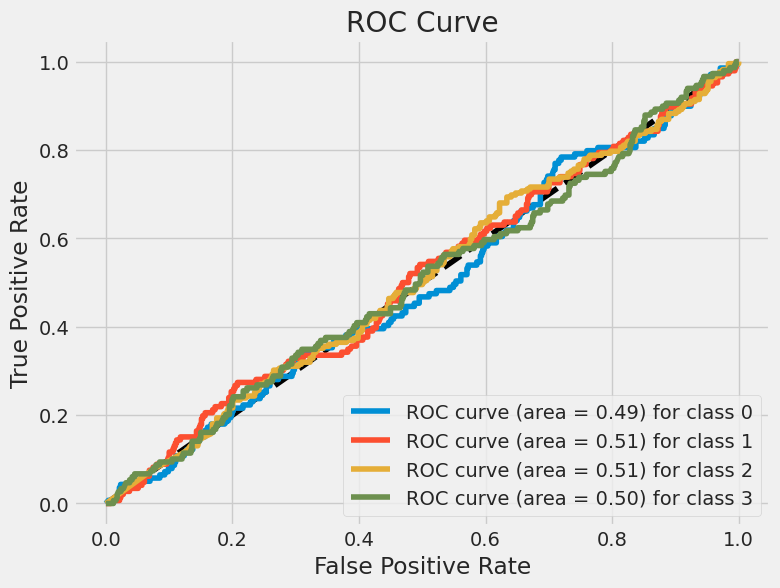

In [27]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the number of classes from the class_indices
num_classes = len(test_generator.class_indices)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Assign test_generator.classes to test_classes
test_classes = test_generator.classes
y_pred_proba = model.predict(test_generator)

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_classes, y_pred_proba[:, i], pos_label=i) # Changed this line
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()